In [1]:
import pandas as pd
from google.colab import files
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from scipy.ndimage.interpolation import shift
from sklearn.metrics import r2_score as reg_acc
from sklearn.metrics import mean_squared_error as mse
from sklearn.neural_network import MLPRegressor as NN
from statsmodels.tsa.arima_model import ARIMA
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.preprocessing import MinMaxScaler
from keras import optimizers
from keras.models import Sequential,Model
from keras.layers import LSTM,Dense,Dropout,Input
from sklearn.neighbors import KNeighborsRegressor as KNN

/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
features=pd.read_csv('gdrive/My Drive/DS Project/Dataset/Dataset 2/features.csv')

In [0]:
stores=pd.read_csv('gdrive/My Drive/DS Project/Dataset/Dataset 2/stores.csv')

In [0]:
train=pd.read_csv('gdrive/My Drive/DS Project/Dataset/Dataset 2/train.csv')

In [0]:
merged_1=train.merge(stores, on=['Store'], how='left')

In [0]:
train=merged_1.merge(features, on=['Store','Date','IsHoliday'], how='left')

In [0]:
nan_values=train.isnull()
nan_values_count=[0]*train.shape[1]
for i in range(train.shape[1]):
  nan_values_count[i]=sum(nan_values.iloc[:,i])

In [0]:
train['MarkDown1']=train['MarkDown1'].fillna(0)
train['MarkDown2']=train['MarkDown2'].fillna(0)
train['MarkDown3']=train['MarkDown3'].fillna(0)
train['MarkDown4']=train['MarkDown4'].fillna(0)
train['MarkDown5']=train['MarkDown5'].fillna(0)

In [0]:
train['month']=pd.DatetimeIndex(train['Date']).month
train['month'] =  train['month'].map(int)
train['week']=pd.DatetimeIndex(train['Date']).day
train['week'] =  ((train['week']/7)+1).map(int)
train.update(train['Type'].replace('A',1))
train.update(train['Type'].replace('B',2))
train.update(train['Type'].replace('C',3))
train['date']=train['Date']
train=train.drop('Date',axis=1)

In [0]:
test=pd.read_csv('gdrive/My Drive/DS Project/Dataset/Dataset 2/test.csv')

In [0]:
merged_1=test.merge(stores, on=['Store'], how='left')
test=merged_1.merge(features, on=['Store','Date','IsHoliday'], how='left')
nan_values=test.isnull()
nan_values_count=[0]*test.shape[1]
for i in range(test.shape[1]):
  nan_values_count[i]=sum(nan_values.iloc[:,i])
test['MarkDown1']=test['MarkDown1'].fillna(0)
test['MarkDown2']=test['MarkDown2'].fillna(0)
test['MarkDown3']=test['MarkDown3'].fillna(0)
test['MarkDown4']=test['MarkDown4'].fillna(0)
test['MarkDown5']=test['MarkDown5'].fillna(0)
test['CPI']=test['CPI'].fillna(np.mean(test['CPI']))
test['Unemployment']=test['Unemployment'].fillna(np.mean(test['Unemployment']))
test['month']=pd.DatetimeIndex(test['Date']).month
test['month'] =  test['month'].map(int)
test['week']=pd.DatetimeIndex(test['Date']).day
test['week'] =  ((test['week']/7)+1).map(int)
test.update(test['Type'].replace('A',1))
test.update(test['Type'].replace('B',2))
test.update(test['Type'].replace('C',3))
test['date']=test['Date']
test=test.drop('Date',axis=1)


In [0]:
train['sales']=train['Weekly_Sales']
train=train.drop('Weekly_Sales',axis=1)
train_date=train['date']
train=train.drop('date',axis=1)
test_date=test['date']
test=test.drop('date',axis=1)

In [0]:
sales=train['sales']
train=train.drop('sales',axis=1)

In [15]:
print(train.shape)
print(test.shape)

(421570, 16)
(115064, 16)


In [16]:
train.head()

,Store,Dept,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,month,week
0,1,1,False,1,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,2,1
1,1,1,True,1,151315,38.51,2.548,0.0,0.0,0.0,0.0,0.0,211.242170,8.106,2,2
2,1,1,False,1,151315,39.93,2.514,0.0,0.0,0.0,0.0,0.0,211.289143,8.106,2,3
3,1,1,False,1,151315,46.63,2.561,0.0,0.0,0.0,0.0,0.0,211.319643,8.106,2,4
4,1,1,False,1,151315,46.50,2.625,0.0,0.0,0.0,0.0,0.0,211.350143,8.106,3,1


In [0]:
train=train[['Store','Dept','IsHoliday','Type','Size','month','week']]
test=test[['Store','Dept','IsHoliday','Type','Size','month','week']]

In [18]:
train.shape

(421570, 7)

In [0]:
train.fillna(0, inplace=True)

In [0]:
scaler=MinMaxScaler(feature_range=(0,1))

In [21]:
scaler.fit(train)
train=scaler.transform(train)
test=scaler.transform(test)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype bool, int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [0]:
encode_dim=4
encoder = Sequential()
encoder.add(Dense(100,activation='relu',input_shape=(train.shape[1],)))
encoder.add(Dense(encode_dim,activation='relu'))

decoder = Sequential()
decoder.add(Dense(100,activation='relu',input_shape=(encode_dim,)))
decoder.add(Dense(train.shape[1],activation='sigmoid'))
#adam=optimizers.adam(lr=0.0001)
x = Input(shape=(train.shape[1],))
encoded = encoder(x)
decoded = decoder(encoded)
model = Model(x, decoded)
model.compile(loss='mean_squared_error', optimizer='adam')

In [23]:
model.fit(train, train, epochs=20, batch_size=100, shuffle=False)

Epoch 1/20
421570/421570 [==============================] - 24s 56us/step - loss: 0.0128
Epoch 2/20
421570/421570 [==============================] - 23s 55us/step - loss: 0.0026
Epoch 3/20
421570/421570 [==============================] - 23s 55us/step - loss: 0.0023
Epoch 4/20
421570/421570 [==============================] - 23s 55us/step - loss: 0.0024
Epoch 5/20
421570/421570 [==============================] - 23s 55us/step - loss: 0.0023
Epoch 6/20
421570/421570 [==============================] - 23s 55us/step - loss: 0.0023
Epoch 7/20
421570/421570 [==============================] - 23s 55us/step - loss: 0.0023
Epoch 8/20
421570/421570 [==============================] - 23s 55us/step - loss: 0.0022
Epoch 9/20
421570/421570 [==============================] - 23s 54us/step - loss: 0.0026
Epoch 10/20
421570/421570 [==============================] - 23s 54us/step - loss: 0.0024
Epoch 11/20
421570/421570 [==============================] - 23s 55us/step - loss: 0.0024
Epoch 12/20
421570/

In [0]:
sales_scale=np.max(sales)

In [0]:
sales=sales/sales_scale

In [0]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [0]:
X_train,X_test,y_train,y_test=train_test_split(train,sales,test_size=0.2)

In [0]:
X_train=encoder.predict(X_train)
X_test=encoder.predict(X_test)

In [29]:
reg=RandomForestRegressor(random_state=43, n_estimators=100, max_depth = 20)
reg.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=43, verbose=0, warm_start=False)

In [0]:
output=reg.predict(X_test)

In [31]:
np.sqrt(mse(output*sales_scale,y_test*sales_scale))

12680.053915222481

In [0]:
def WMAE(y_pred,y_true):
  return np.sum(np.abs(y_pred - y_true))

In [33]:
WMAE(output*sales_scale,y_test*sales_scale)

651983694.9011177

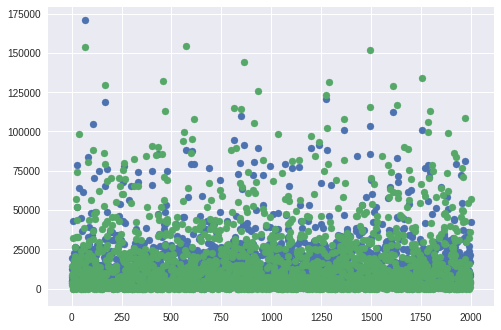

In [34]:
indices=np.arange(2000)
plt.scatter(indices,output[:2000]*sales_scale)
plt.scatter(indices,y_test[:2000]*sales_scale)

In [0]:
submission=pd.read_csv('gdrive/My Drive/DS Project/Dataset/Dataset 2/sampleSubmission.csv')

In [36]:
submission.shape

(115064, 2)

In [0]:
out=encoder.predict(test)
out=reg.predict(out)

In [0]:
out=out*sales_scale

In [0]:
submission['Weekly_Sales']=out

In [40]:
submission.head()

,Id,Weekly_Sales
0,1_1_2012-11-02,38143.045490
1,1_1_2012-11-09,28704.573496
2,1_1_2012-11-16,28357.755016
3,1_1_2012-11-23,23786.050686
4,1_1_2012-11-30,38100.220730


In [0]:
submission.to_csv('gdrive/My Drive/DS Project/Nabeel/out_AE.csv',index=False)